### Build text classification models using PyTorch¶
- Load data into pandas dataframe
- Encode categorical label values into integer type
- Split data into train and test subset using 80/20 ratio
- Extract texts into padded sequence matrix
- Build and train models
- Evaluate model performace

In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#### Load data into pandas dataframe

In [22]:
df = pd.read_csv('bbc-text.csv')
print(df.shape, df['category'].nunique())
df.head(2)

(2225, 2) 5


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


#### Encode categorical lable values into integers

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["category"])
df['encoded_cat'] = le.transform(df['category'])

In [24]:
df.head(2)

,category,text,encoded_cat
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0


#### Split data into train and test subset using 80/20 split, we will train model using train data and test the model using test dataset

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    df['text'], df['encoded_cat'], test_size=.2, stratify=df['category'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1780,) (445,) (1780,) (445,)


#### Convert text into sequence integers 

In [26]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_seq = tokenizer.texts_to_sequences(x_train)

#### Check the maximum number of sequences in sample data

In [27]:
max([len(e) for e in x_seq])

4491

#### Add padding to sequence so all rows have the same length, so the input texts can become a matrix

In [28]:
padding_type = 'post'
max_len = 5000
x_train = pad_sequences(x_seq, padding=padding_type, maxlen=max_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), padding=padding_type, maxlen=max_len)

In [29]:
x_train.shape

(1780, 5000)

#### Construct a simple multi-layer perceptions network
- Add word embedding layer
- Apply GlobalAveragePooling1D

In [51]:
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, 32, input_length=x_train.shape[1]),
                            tf.keras.layers.GlobalAveragePooling1D(),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(df['category'].nunique(), activation='softmax')
])

In [52]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 5000, 32)          640000    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 32)                0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 165       
Total params: 641,221
Trainable params: 641,221
Non-trainable params: 0
_______________________________________________

#### Train the neural network with 70 epochs, store the train and test loss so we can plot the training results

In [53]:
%%time
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose=2)

Epoch 1/50
56/56 - 1s - loss: 1.6072 - accuracy: 0.2180 - val_loss: 1.6030 - val_accuracy: 0.2292
Epoch 2/50
56/56 - 1s - loss: 1.6017 - accuracy: 0.2292 - val_loss: 1.5999 - val_accuracy: 0.2292
Epoch 3/50
56/56 - 1s - loss: 1.5984 - accuracy: 0.2388 - val_loss: 1.5968 - val_accuracy: 0.2292
Epoch 4/50
56/56 - 1s - loss: 1.5966 - accuracy: 0.2500 - val_loss: 1.5926 - val_accuracy: 0.2292
Epoch 5/50
56/56 - 1s - loss: 1.5903 - accuracy: 0.2449 - val_loss: 1.5860 - val_accuracy: 0.2292
Epoch 6/50
56/56 - 1s - loss: 1.5815 - accuracy: 0.2685 - val_loss: 1.5756 - val_accuracy: 0.2337
Epoch 7/50
56/56 - 1s - loss: 1.5694 - accuracy: 0.2478 - val_loss: 1.5578 - val_accuracy: 0.2360
Epoch 8/50
56/56 - 1s - loss: 1.5455 - accuracy: 0.3292 - val_loss: 1.5248 - val_accuracy: 0.5798
Epoch 9/50
56/56 - 1s - loss: 1.5058 - accuracy: 0.3938 - val_loss: 1.4761 - val_accuracy: 0.3978
Epoch 10/50
56/56 - 1s - loss: 1.4479 - accuracy: 0.4624 - val_loss: 1.4110 - val_accuracy: 0.4449
Epoch 11/50
56/56 -

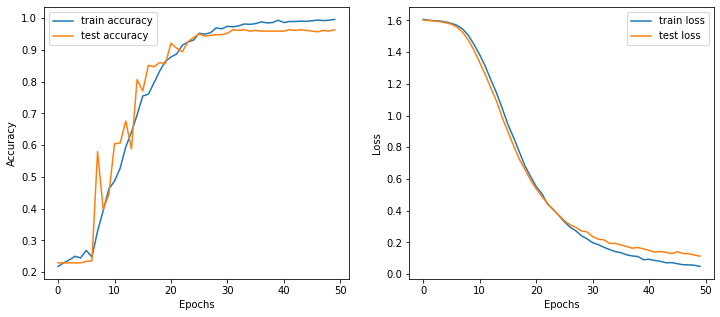

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);

#### Result:
The training process took about 41 seconds to complete. After 26 epochs the test accuracy reached 95%, and after 32 epoches the accuracy stayed at 96%